In [16]:
from qiskit.transpiler.coupling import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger
from mirror_gates.sqiswap_decomposer import SiSwapDecomposePass
from qiskit.transpiler.passmanager import PassManager
from qiskit import Aer, transpile
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    pauli_error,
    depolarizing_error,
    thermal_relaxation_error,
    RelaxationNoisePass,
)
from qiskit.circuit import Delay
from qiskit.transpiler.passes import PadDelay, ASAPSchedule
from qiskit import QuantumCircuit

from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from qiskit.circuit.library import iSwapGate
from qiskit.transpiler import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from mirror_gates.utilities import SubsMetric
from mirror_gates.logging import transpile_benchy_logger

In [17]:
N = 8
coupling_map = CouplingMap.from_line(8)

In [18]:
from transpile_benchy.library import CircuitLibrary

library = CircuitLibrary.from_txt("../../circuits/small_circuits.txt")

In [19]:
# new metric for simulating fidelity
from transpile_benchy.metrics.abc_metrics import MetricInterface
from qiskit.transpiler.basepasses import AnalysisPass
from mirror_gates.noisy_fidelity import get_noisy_fidelity
from qiskit.converters import dag_to_circuit
from mirror_gates.utilities import DoNothing

# TODO: we could move gate times and T1,T2 to be parameters
# currently, are just hardcoded at the top of the file


class FidelityAnalysis(AnalysisPass):
    def __init__(self, coupling_map, sqrt_iswap_basis):
        super().__init__()
        self.coupling_map = coupling_map
        self.sqrt_iswap_basis = sqrt_iswap_basis

    def run(self, dag):
        qc = dag_to_circuit(dag)
        fid, duration, _, expected_fid = get_noisy_fidelity(
            qc, self.coupling_map, sqrt_iswap_basis=self.sqrt_iswap_basis
        )
        self.property_set["noisy_fidelity"] = fid
        self.property_set["scheduled_duration"] = duration
        self.property_set["expected_fidelity"] = expected_fid
        return dag


class FidelityMetric(MetricInterface):
    """Calculate the noisy simulated fidelity."""

    def __init__(self, coupling_map):
        """Initialize the metric."""
        super().__init__(name="noisy_fidelity", pretty_name="Noisy Fidelity")
        self.use_geometric_mean = True
        self.coupling_map = coupling_map

    def _construct_pass(self, basis_gate):
        """Return the pass associated with this metric."""
        sqrt_iswap_basis = basis_gate == iSwapGate().power(1 / 2)
        return FidelityAnalysis(self.coupling_map, sqrt_iswap_basis)


class DurationMetric(MetricInterface):
    """Calculate the noisy simulated fidelity."""

    def __init__(self):
        """Initialize the metric."""
        super().__init__(name="scheduled_duration", pretty_name="Circuit Duration (ns)")
        self.use_geometric_mean = True

    def _construct_pass(self):
        """Return the pass associated with this metric."""
        return DoNothing()


class ExpectedFidelityMetric(MetricInterface):
    """Calculate the noisy simulated fidelity."""

    def __init__(self):
        """Initialize the metric."""
        super().__init__(name="expected_fidelity", pretty_name="Expected Fidelity")
        self.use_geometric_mean = True

    def _construct_pass(self):
        """Return the pass associated with this metric."""
        return DoNothing()

In [20]:
# XXX set consolidate to False
# this is allowed only because my pass manager will preserve consolidation
# see post_stage, I call fastconsolidate manually

# NOTE: use TotalSwaps to verify baselines have > 0 swaps
# otherwise, there is no room for improvement.
# we can include these if we want to show our methods will still work
# but somewhat trivial since we just append VF2Layout
metrics = [
    DepthMetric(consolidate=False),
    TotalMetric(consolidate=False),
    TotalSwaps(consolidate=False),
    SubsMetric(),
    FidelityMetric(coupling_map),
    DurationMetric(),
    ExpectedFidelityMetric(),
]

transpilers = [
    # QiskitLevel3(coupling_map, cx_basis=True),
    # Mirage(
    #     coupling_map,
    #     logger=transpile_benchy_logger,
    #     cx_basis=True,
    # ),
    QiskitLevel3(coupling_map, cx_basis=False),
    Mirage(
        coupling_map,
        logger=transpile_benchy_logger,
        cx_basis=False,
    ),
]

In [21]:
from transpile_benchy.benchmark import Benchmark

benchmark = Benchmark(
    transpilers=transpilers,
    circuit_library=library,
    metrics=metrics,
    logger=transpile_benchy_logger,
    num_runs=1,
)

benchmark.run()

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)


INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


Circuits from library:   0%|          | 0/7 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit toffoli_n3


Loading toffoli_n3 from Hardcoded


Circuits from library:  14%|█▍        | 1/7 [00:08<00:50,  8.36s/it]INFO:transpile_benchy:Running benchmark for circuit fredkin_n3


Loading fredkin_n3 from Hardcoded


Circuits from library:  29%|██▊       | 2/7 [00:17<00:44,  8.84s/it]INFO:transpile_benchy:Running benchmark for circuit dj_n8


Loading dj_n8 from Hardcoded


Circuits from library:  43%|████▎     | 3/7 [00:26<00:35,  8.87s/it]INFO:transpile_benchy:Running benchmark for circuit qft_n4


Loading qft_n4 from QASMBench


Circuits from library:  57%|█████▋    | 4/7 [00:35<00:26,  8.95s/it]INFO:transpile_benchy:Running benchmark for circuit qftentangled_n8


Loading qftentangled_n8 from Hardcoded


Circuits from library:  71%|███████▏  | 5/7 [00:55<00:25, 12.81s/it]INFO:transpile_benchy:Running benchmark for circuit qpeexact_n8


Loading qpeexact_n8 from Hardcoded


Circuits from library:  86%|████████▌ | 6/7 [01:14<00:14, 15.00s/it]INFO:transpile_benchy:Running benchmark for circuit ae_n8


Loading ae_n8 from Hardcoded


Circuits from library: 100%|██████████| 7/7 [01:31<00:00, 13.04s/it]


In [22]:
print(benchmark)


Transpiler: Mirage-$\sqrt{\texttt{iSWAP}}$

  Metric: accepted_subs
  Circuit: ae_n8                                    Mean result: 0.963                          Trials: [0.9629629629629629]
  Circuit: dj_n8                                    Mean result: 0.500                          Trials: [0.5]
  Circuit: fredkin_n3                               Mean result: 0.500                          Trials: [0.5]
  Circuit: qft_n4                                   Mean result: 0.800                          Trials: [0.8]
  Circuit: qftentangled_n8                          Mean result: 0.526                          Trials: [0.5263157894736842]
  Circuit: qpeexact_n8                              Mean result: 0.733                          Trials: [0.7333333333333333]
  Circuit: toffoli_n3                               Mean result: 0.250                          Trials: [0.25]

  Metric: expected_fidelity
  Circuit: ae_n8                                    Mean result: 1.000                

In [24]:
benchmark.summary_statistics(transpilers[0], transpilers[1])

{'monodromy_depth': {'average_change': -21.364606787561335,
  'aggregrate_change': -17.22222222222222,
  'best_circuit': 'ae_n8',
  'worst_circuit': 'qftentangled_n8'},
 'monodromy_total': {'average_change': -16.828506613768216,
  'aggregrate_change': -9.578544061302702,
  'best_circuit': 'fredkin_n3',
  'worst_circuit': 'qpeexact_n8'},
 'total_swaps': {'average_change': -68.74338624338624,
  'aggregrate_change': -35.955056179775276,
  'best_circuit': 'toffoli_n3',
  'worst_circuit': 'qpeexact_n8'},
 'accepted_subs': {'average_change': inf,
  'aggregrate_change': inf,
  'best_circuit': 'toffoli_n3',
  'worst_circuit': 'toffoli_n3'},
 'noisy_fidelity': {'average_change': 8.53366822658661,
  'aggregrate_change': 6.573233354398264,
  'best_circuit': 'qpeexact_n8',
  'worst_circuit': 'ae_n8'},
 'scheduled_duration': {'average_change': -22.572349761551212,
  'aggregrate_change': -17.695852534562203,
  'best_circuit': 'fredkin_n3',
  'worst_circuit': 'qftentangled_n8'},
 'expected_fidelity':

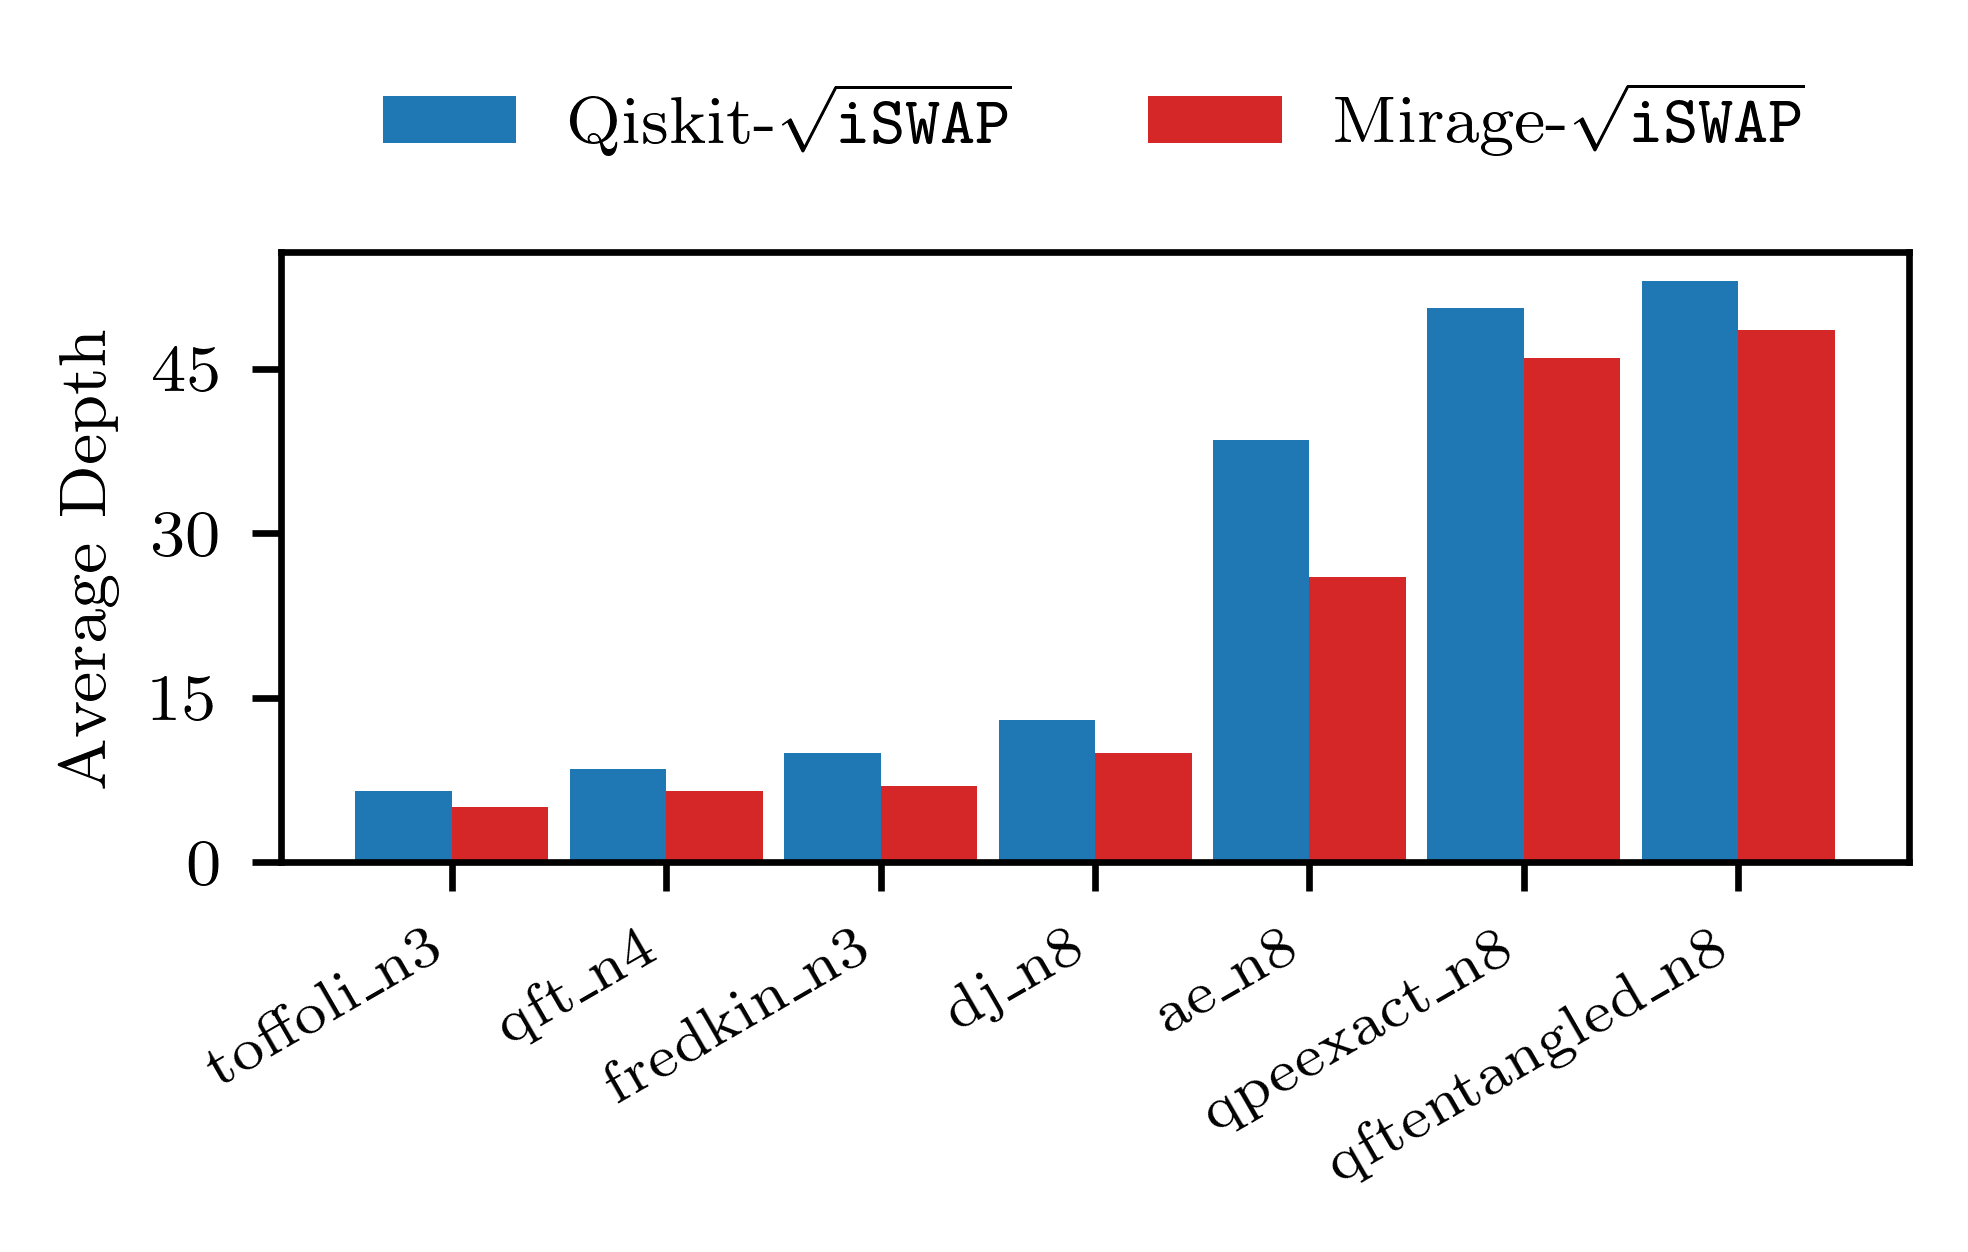

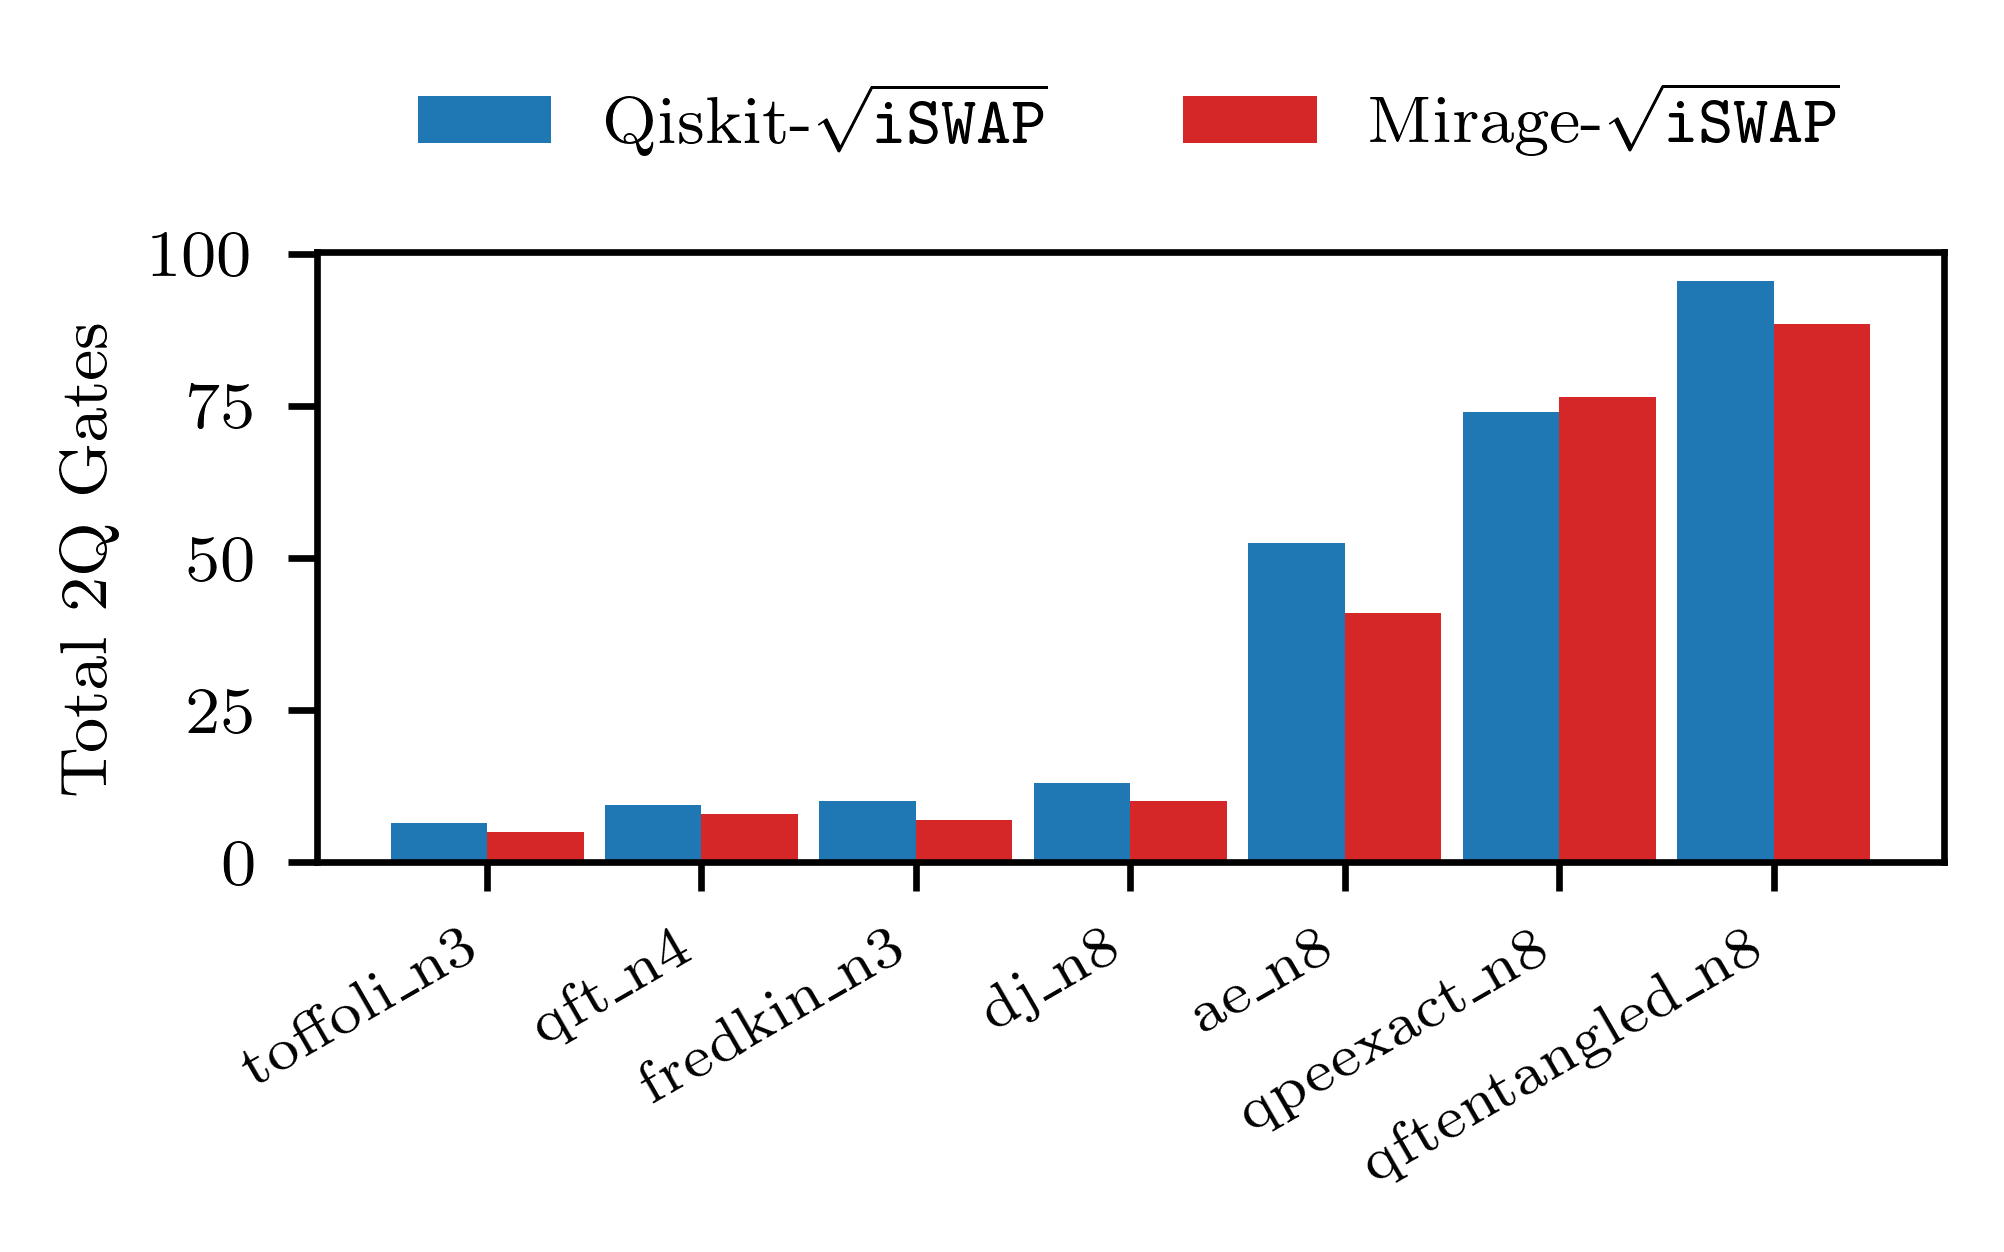

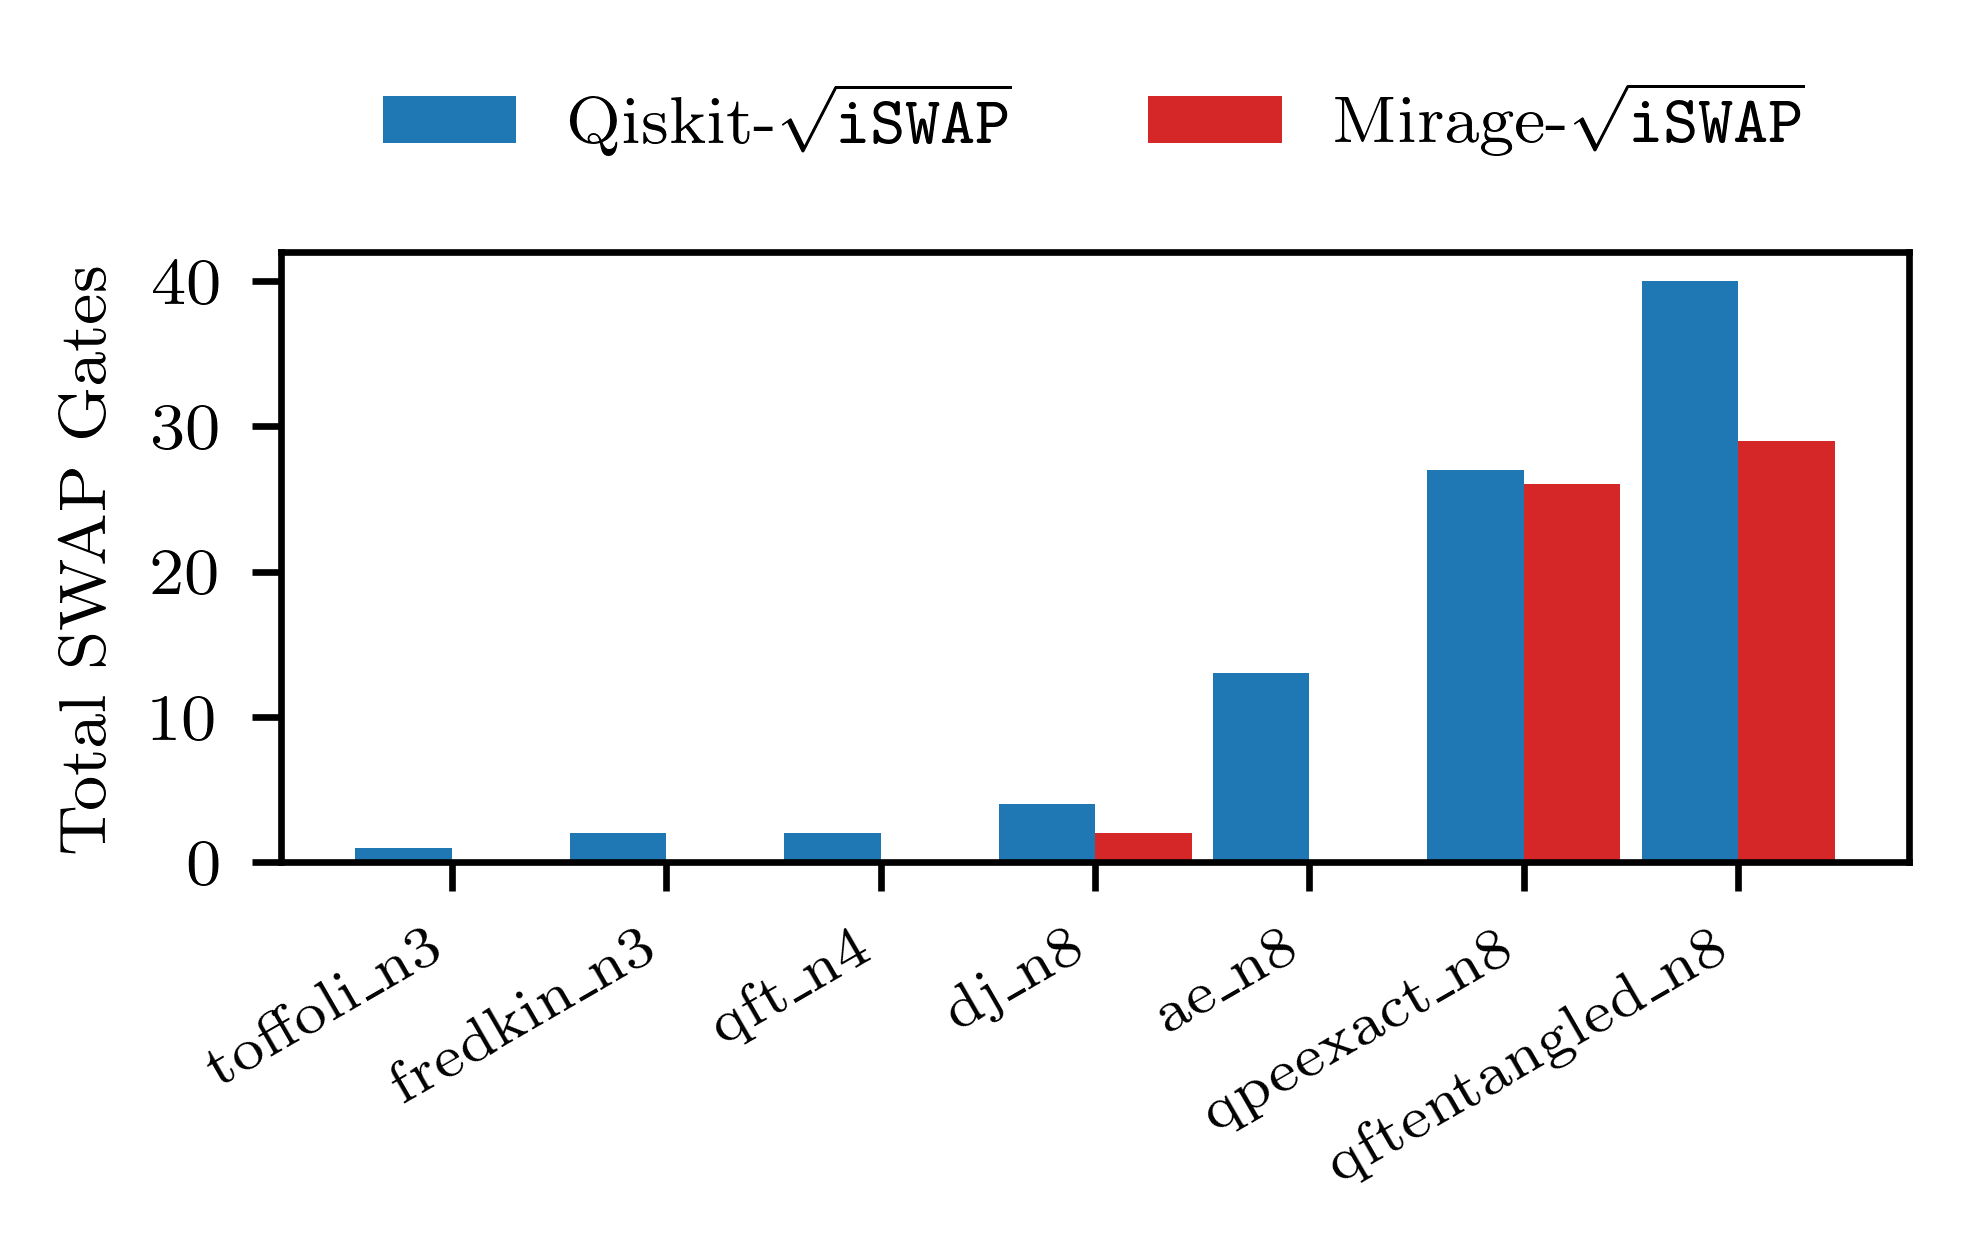

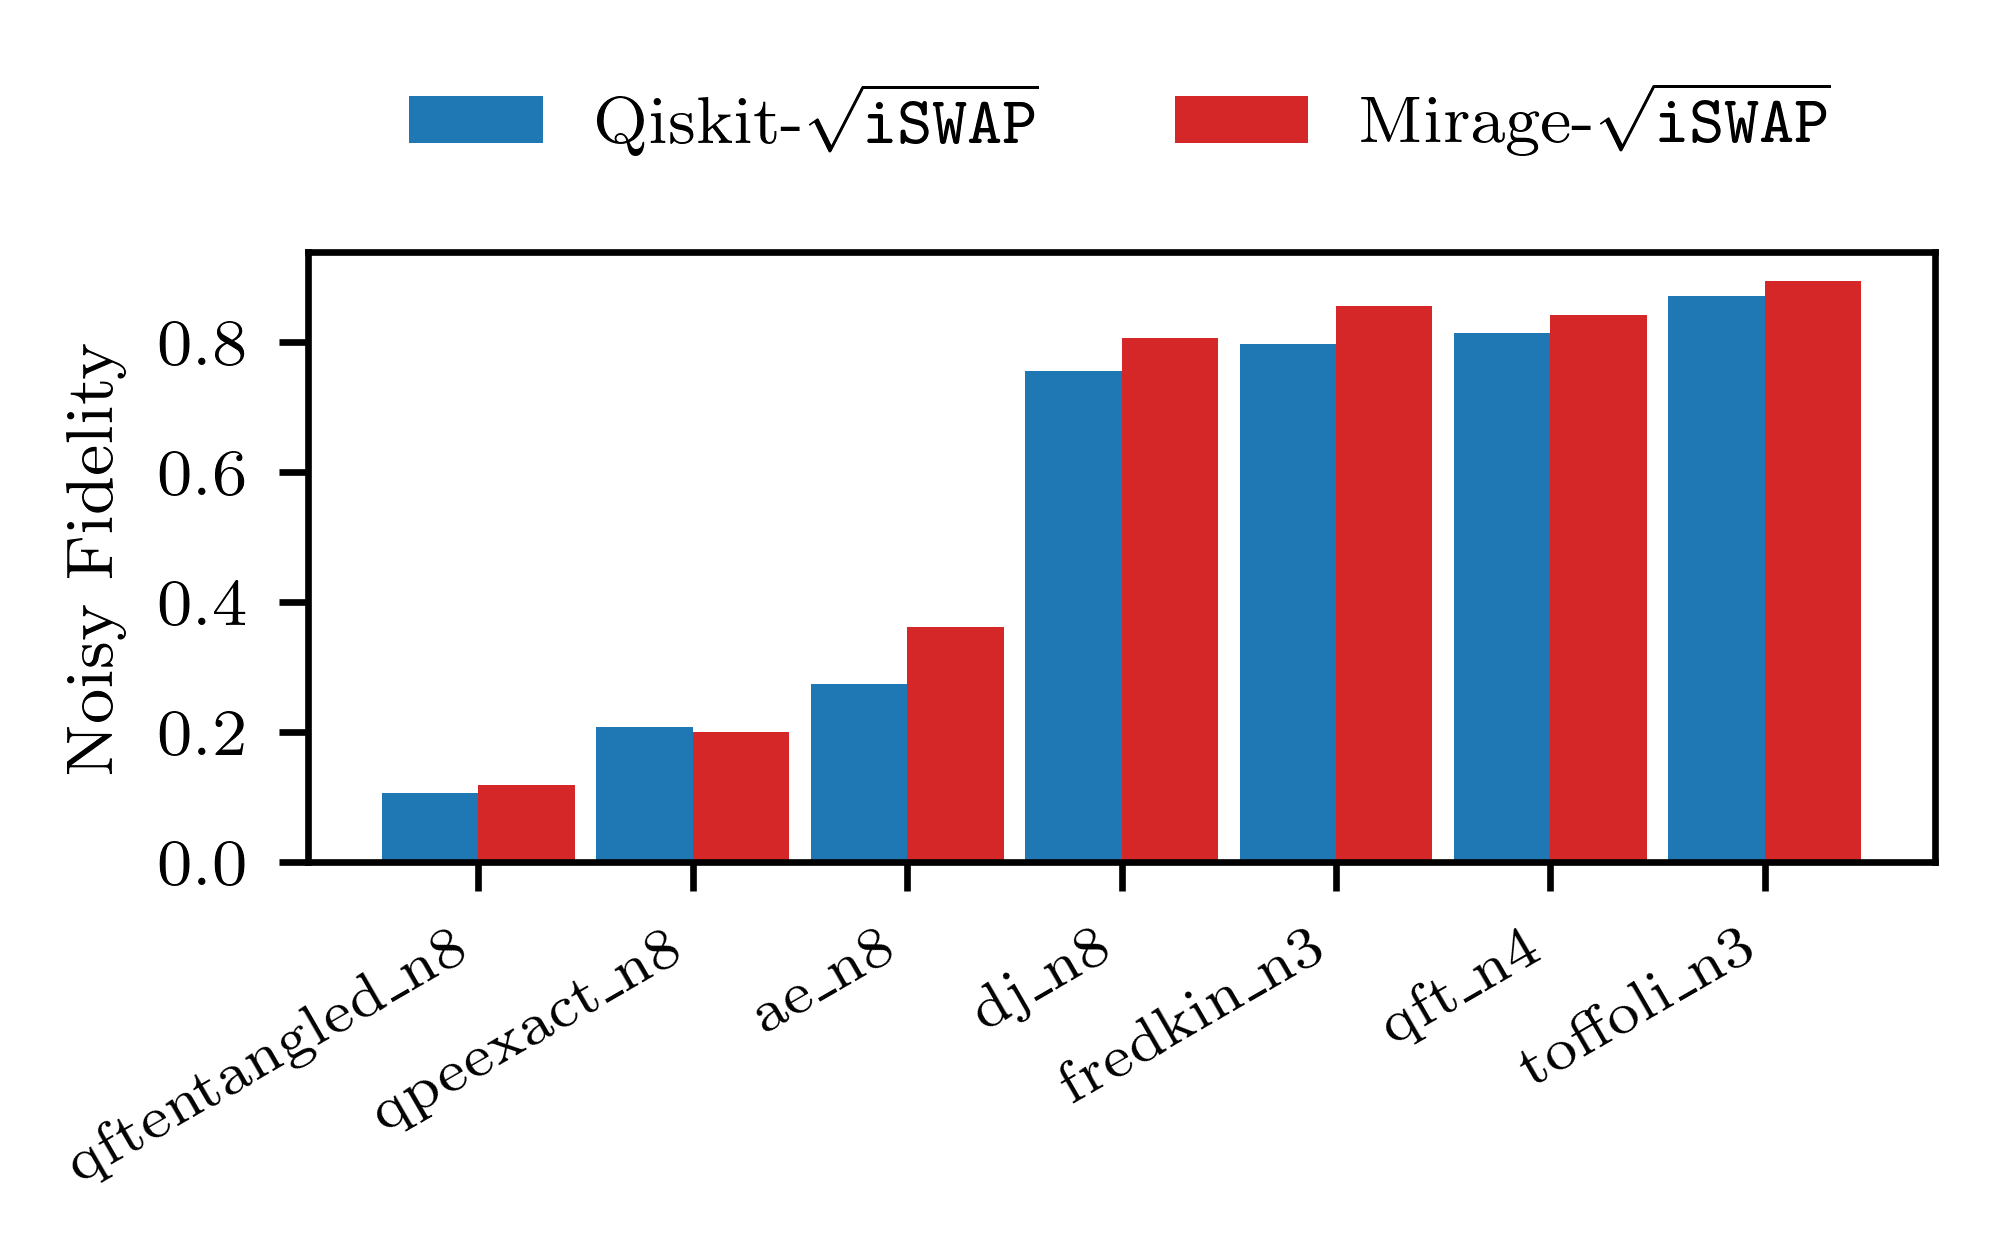

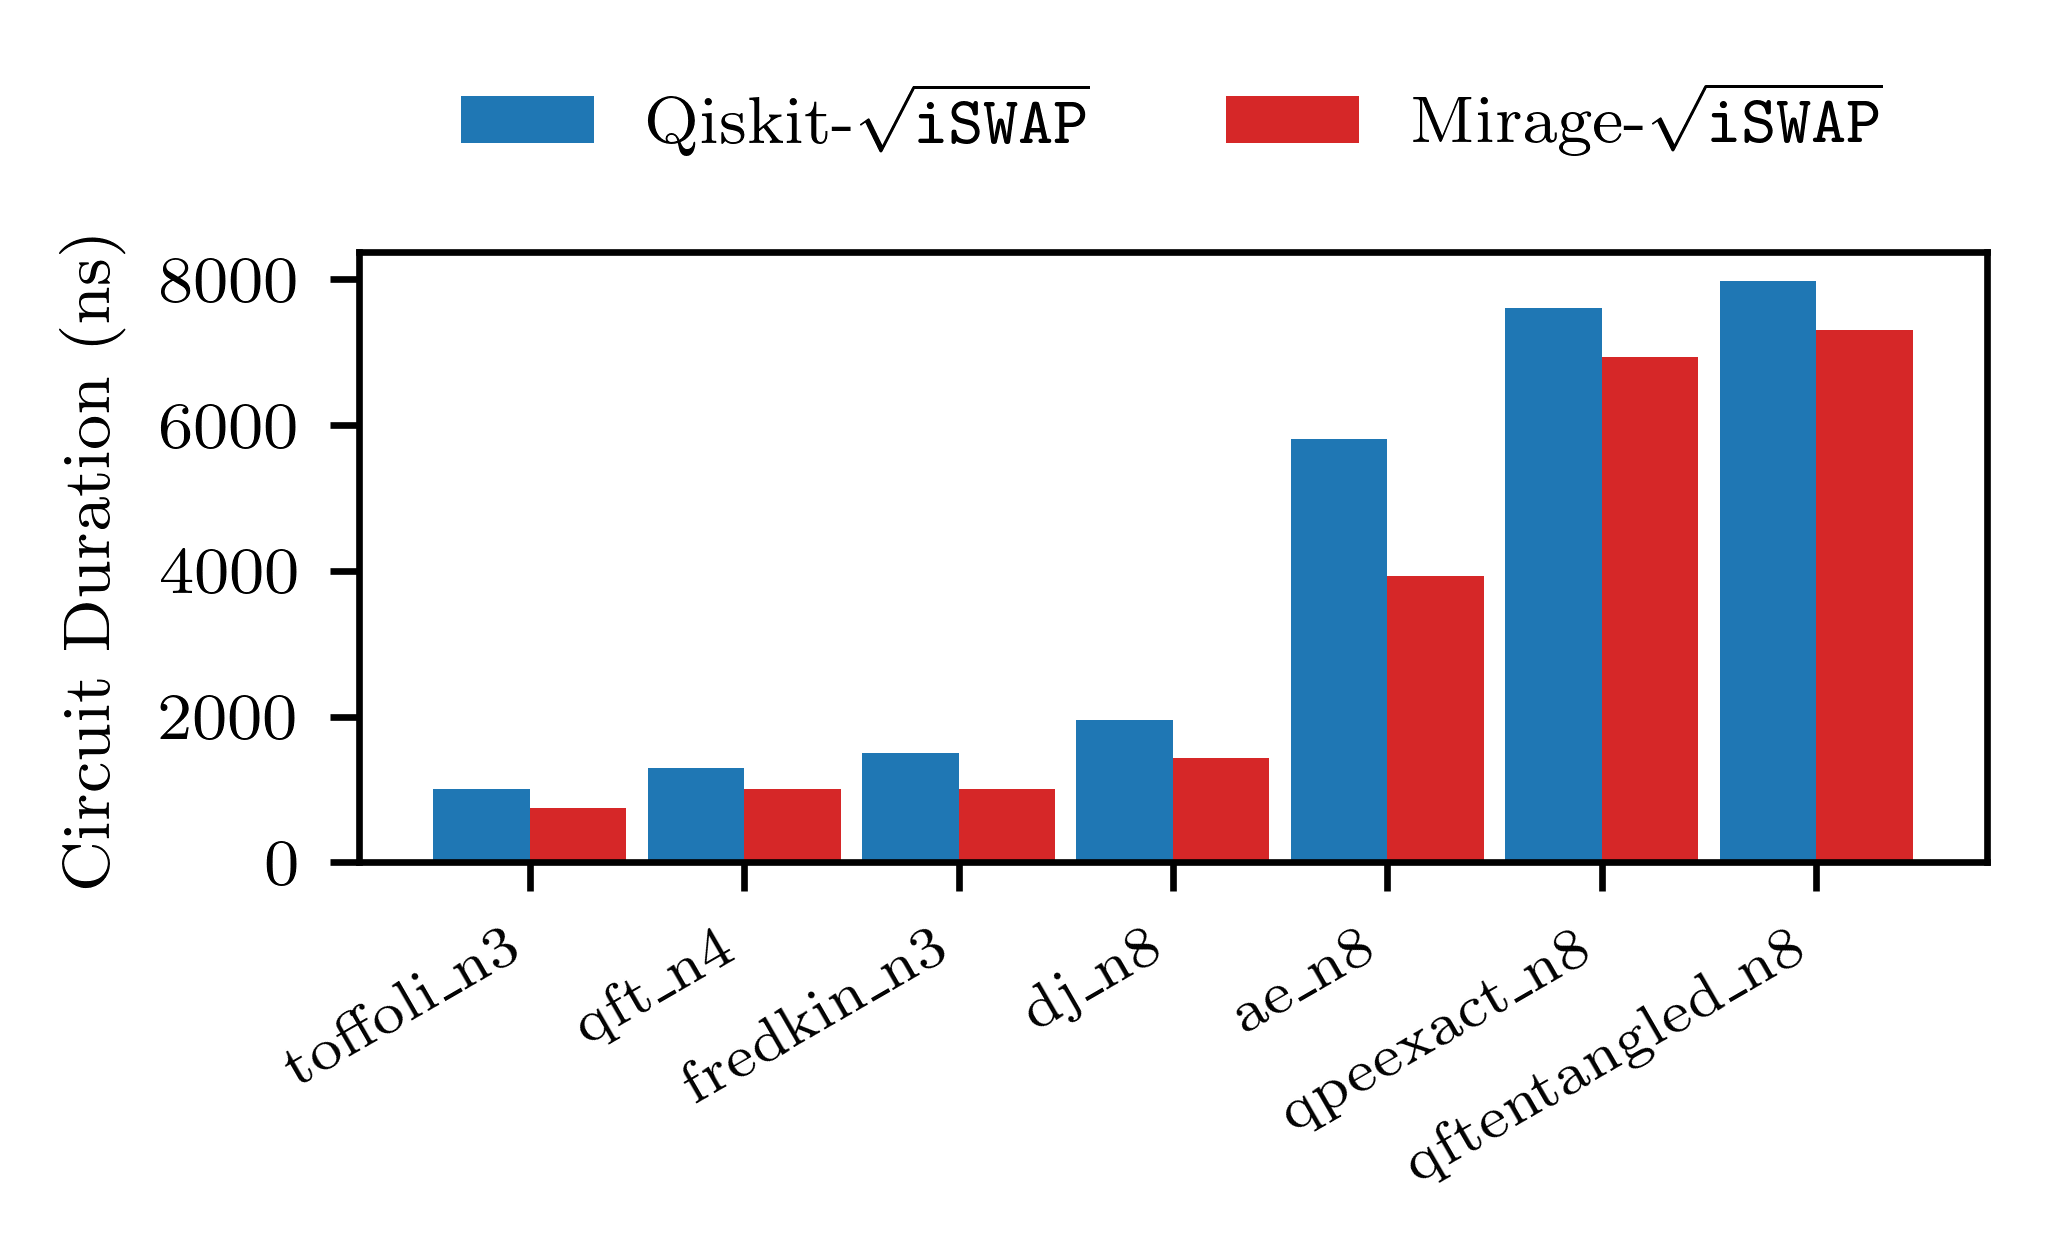

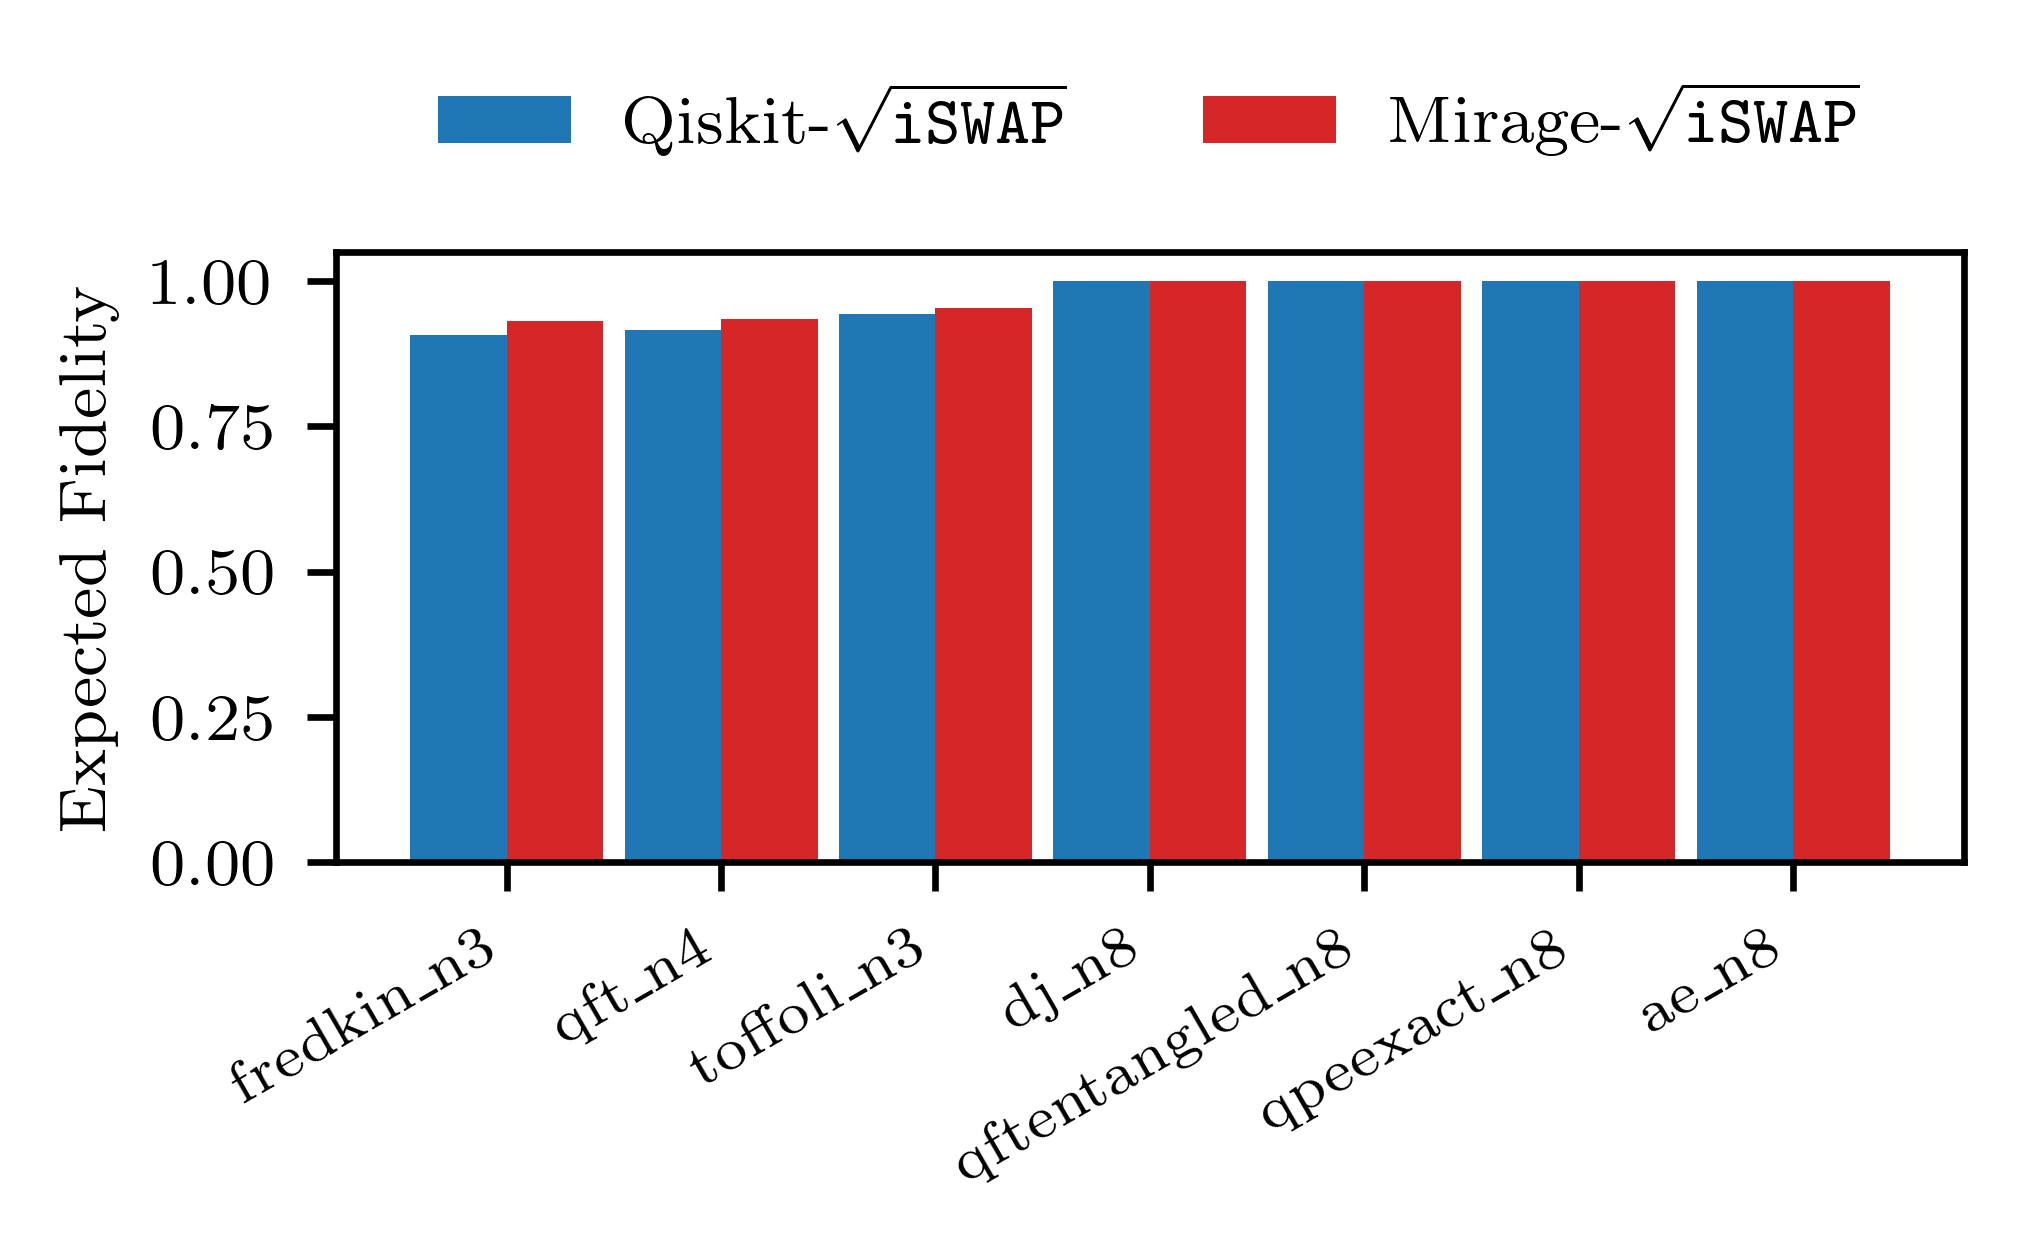

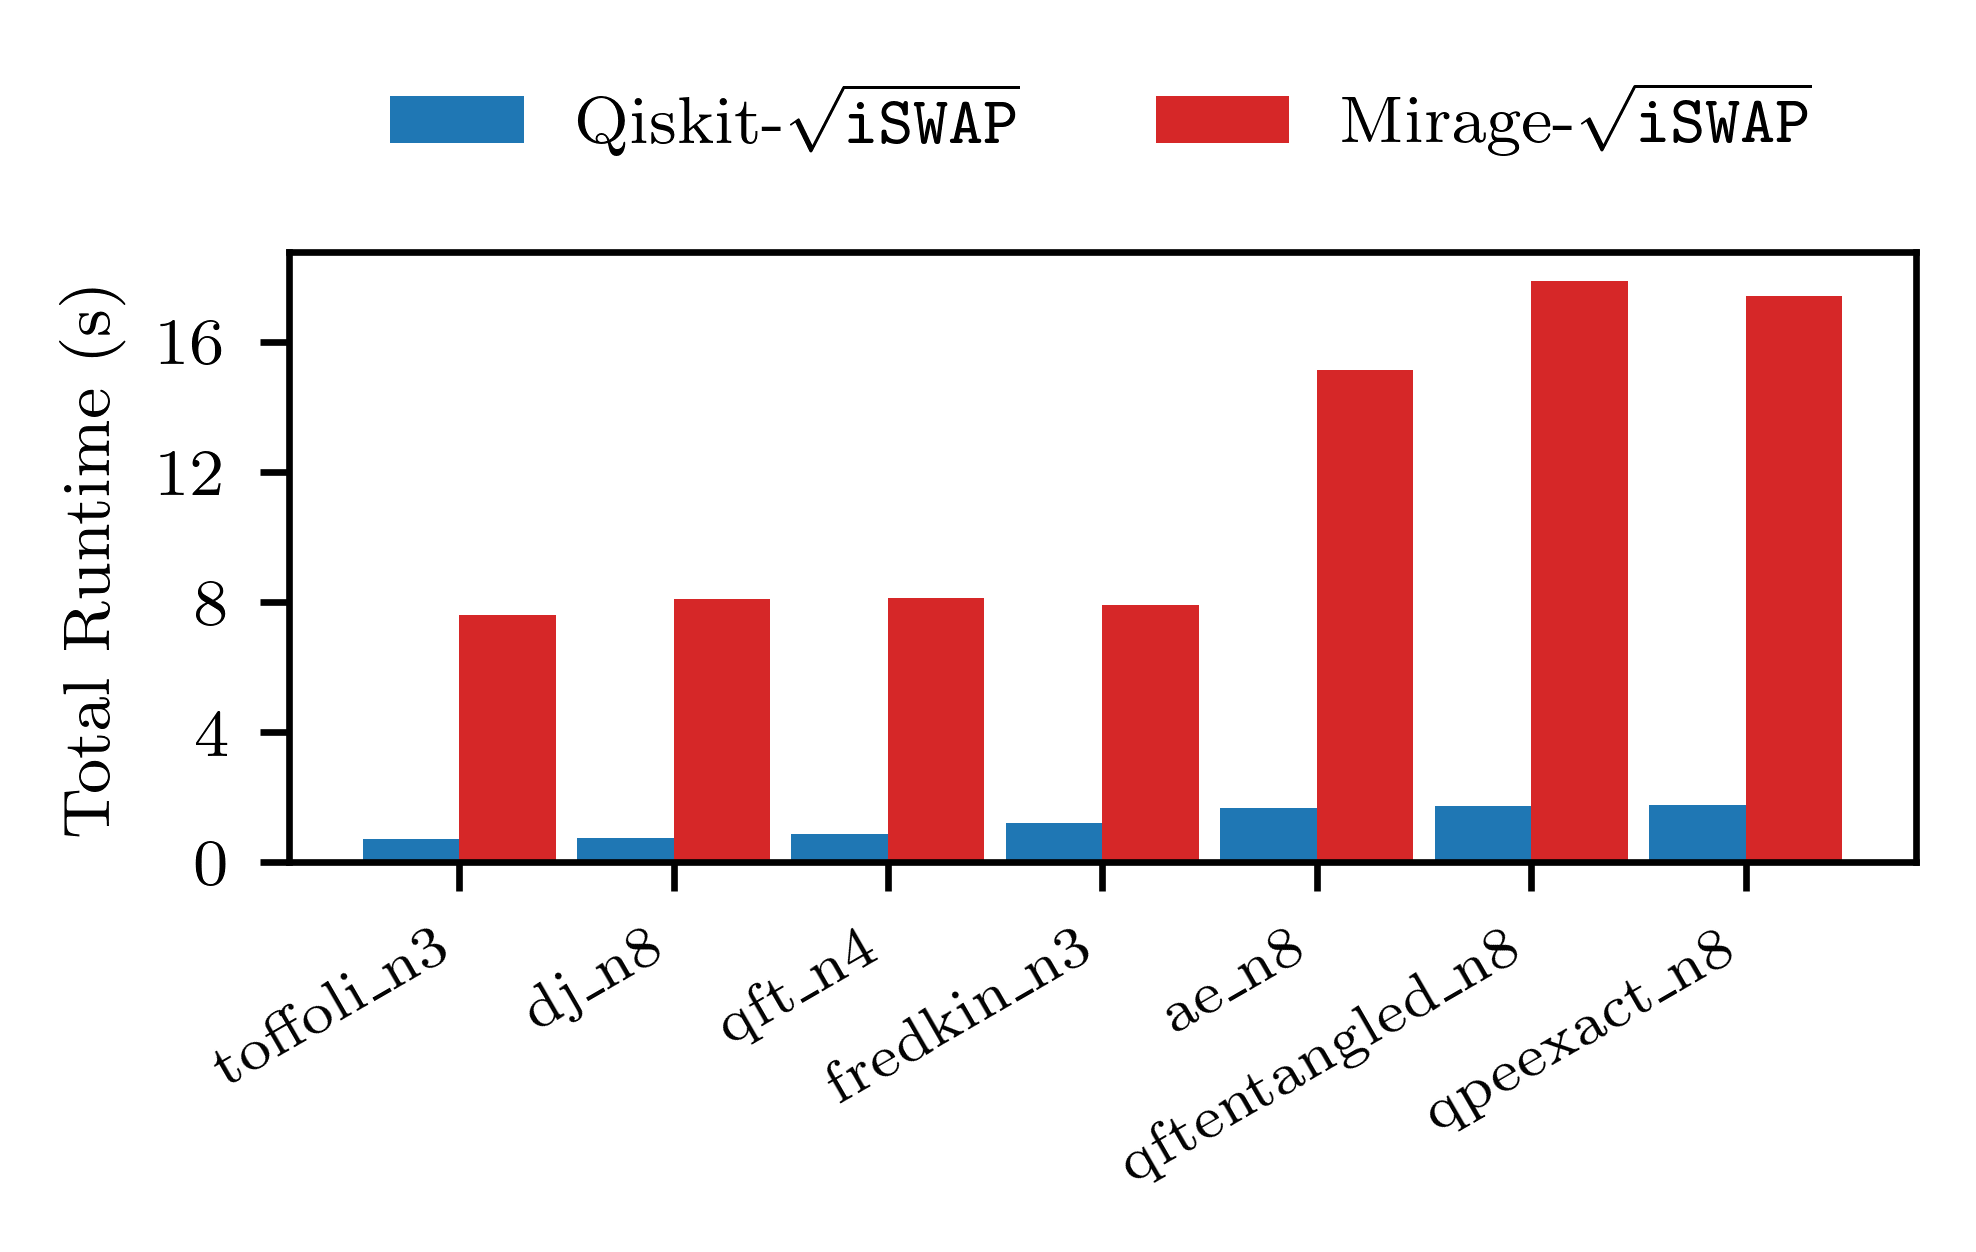

In [28]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(
    benchmark,
    save=1,
    legend_show=1,
    filename="twolocal",
    color_override=[0, 3],
)